In [1]:
import numpy as np
from sklearn.decomposition import FastICA, PCA
from scipy import signal
from picard import Picard
from scipy.stats import entropy

import matplotlib.pyplot as plt
import mplhep as hep

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider, Dropdown, FloatSlider

import seaborn as sns

import warnings

# from src.data_utils import toy_time
from src.mutual_info import entropy, kl_divergence, amari_error
from src.gradient_models import GradientICA, NaturalGradientICA
from src.misc import colors
from src.jadeR import jadeR

%load_ext autoreload
%autoreload 2

## Análise de Componentes Independentes (ICA)
.

### Implementação e Visualização

Utilizamos a biblioteca `sklearn` para aplicar o ICA, por meio da classe `Fas Além disso, as próximas células desse notebook explorarão outros métodos de obter os componentes indepentendes: `JADE`, `GradientICA`, `NaturalGrtICA`. Este exemplo demonstra como misturar e depois separar sinais usando diferentes distribuições de probabilidade. Cada distribuição representa uma "fonte" diferente em nosso exemplo simulado. As fontes são então combinadas em um único sinal composto, que o ICA tentará separar de volta em componentes independentes.

#### Funções Definidas:

- `generate_mixed_signals`: Gera sinais misturados a partir de distribuições especificadas.
- `amari_error`: Calcula o Erro de Amari entre a matriz de mistura verdadeira e a estimada.
- `kl_divergence`: Calcula a divergência KL entre os componentes originais e os estimados.
- `plot_results`: Visualiza os sinais originais, misturados, e os componentes estimados pelo ICA.

### Erro de Amari

O Erro de Amari é uma medida que quantifica o quão diferente uma matriz estimada é de uma matriz de mistura original. É definido como:

$$
\sum_{i=1}^n \left( \sum_{j=1}^n \frac{|p_{ij}|}{\max_k |p_{ik}|} - 1 \right) + \sum_{j=1}^n\left(\sum_{i=1}^n \frac{|p_{ji}|}{\max_k |p_{jk}|} - 1 \right), P = A^{-1} B
$$

onde $A$ é a matriz de mistura verdadeira, $B$ é a matriz de mistura estimada.

### Experimento Interativo

O código inclui widgets interativos para selecionar diferentes tipos de distribuição para as fontes, ajustar o número de amostras e a amplitude do ruído. Isso permite experimentar como diferentes configurações influenciam a eficácia do ICA na separação de componentes.

## FastICA

In [2]:


def generate_mixed_signals(distributions, n_samples, noise_amp):
    distribution_map = {
        'gaussian': lambda size: np.random.normal(0, 1, size),
        'uniform': lambda size: np.random.uniform(-2, 2, size),
        'laplace': lambda size: np.random.laplace(0, 1, size),
        'triangular': lambda size: np.random.triangular(-3, 0, 3, size),
        'exponential': lambda size: np.random.exponential(1, size)
    }
    
    S = np.vstack([distribution_map[dist](n_samples) for dist in distributions]).T
    A = np.array([[0.5, 0.2, 0.1, 0.2],
                  [0.1, 0.5, 0.2, 0.2],
                  [0.2, 0.1, 0.5, 0.2],
                  [0.2, 0.2, 0.2, 0.4]])
    X = np.dot(S, A) + np.random.normal(0, noise_amp, S.shape)
    return S, X, A


def plot_results(S, X, S_est, A, A_est):
    plt.figure(figsize=(20, 16))

    for i in range(4):
        plt.subplot(4, 4, i + 1)
        plt.hist(S[:, i], bins=50, color=colors[i], alpha=0.75)
        plt.title(f'Source {i+1}')

    for i in range(4):
        plt.subplot(4, 4, i + 5)
        plt.hist(X[:, i], bins=50, color='gray', alpha=0.75)
        plt.title(f'Mixed {i+1}')

    for i in range(4):
        plt.subplot(4, 4, i + 9)
        plt.hist(S_est[:, i], bins=50, color=colors[i], alpha=0.75)
        plt.title(f'Estimated Source {i+1}')

    error = amari_error(A, A_est)
    kl_matrix = np.zeros((S.shape[1], S.shape[1]))
    for i in range(S.shape[1]):
        for j in range(S.shape[1]):
            kl, _ = kl_divergence(S[:, i], S_est[:, j])
            kl_matrix[i,j] = kl
    
    plt.subplot(4, 2, 7)
    sns.heatmap(np.array([[error]]), annot=True, cmap="viridis", cbar=False,  annot_kws={"size": 50})
    plt.title('Amari Error')

    plt.subplot(4, 2, 8)
    sns.heatmap(kl_matrix, annot=True, cmap="viridis")
    plt.title('KL Divergence')

    plt.tight_layout()
    plt.show()

def interactive_ica(source1, source2, source3, source4, n_samples, noise_amp, run_ica):
    distributions = [source1, source2, source3, source4]
    S, X, A = generate_mixed_signals(distributions, n_samples, noise_amp)
    S_est, A_est = run_ica(X)
    plot_results(S, X, S_est, A, A_est)


# Example of a user-defined ICA function (placeholder)
def run_ica_example(X):
    n_components = 4
    algorithm = "parallel" # paralell, "deflation
    fun = "logcosh" # logcosh, exp, cube (kurtosis)
    ica = FastICA(n_components=n_components, algorithm=algorithm, fun=fun)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix

    return S_, A_

distribution_choices = ['gaussian', 'uniform', 'laplace', 'triangular', 'exponential']
interact(lambda source1, source2, source3, source4, n_samples, noise_amp: interactive_ica(source1, source2, source3, source4, n_samples, noise_amp, run_ica_example),
         source1=Dropdown(options=distribution_choices, value='uniform', description='Source 1'),
         source2=Dropdown(options=distribution_choices, value='uniform', description='Source 2'),
         source3=Dropdown(options=distribution_choices, value='uniform', description='Source 3'),
         source4=Dropdown(options=distribution_choices, value='uniform', description='Source 4'),
         n_samples=IntSlider(min=1000, max=100000, step=10000, value=50000, description='Samples'),
         noise_amp=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Noise Amplitude'))


interactive(children=(Dropdown(description='Source 1', index=1, options=('gaussian', 'uniform', 'laplace', 'tr…

<function __main__.<lambda>(source1, source2, source3, source4, n_samples, noise_amp)>

## JADE

In [3]:
# Example of a user-defined ICA function (placeholder)
def run_ica_example(X):
    n_components = 4
    # Apply JADE using jadeR
    B = jadeR(X.T, m=n_components, verbose=False)  # B is the unmixing matrix
    S_ = B @ X.T  # Recover signals
    A_ = B # for standardization
    A_ = np.asarray(A_)
    S_ = np.asarray(S_.T) # np.matrix -> np.array
    

    return S_, A_

distribution_choices = ['gaussian', 'uniform', 'laplace', 'triangular', 'exponential']
interact(lambda source1, source2, source3, source4, n_samples, noise_amp: interactive_ica(source1, source2, source3, source4, n_samples, noise_amp, run_ica_example),
         source1=Dropdown(options=distribution_choices, value='uniform', description='Source 1'),
         source2=Dropdown(options=distribution_choices, value='uniform', description='Source 2'),
         source3=Dropdown(options=distribution_choices, value='uniform', description='Source 3'),
         source4=Dropdown(options=distribution_choices, value='uniform', description='Source 4'),
         n_samples=IntSlider(min=1000, max=100000, step=10000, value=50000, description='Samples'),
         noise_amp=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Noise Amplitude'))

interactive(children=(Dropdown(description='Source 1', index=1, options=('gaussian', 'uniform', 'laplace', 'tr…

<function __main__.<lambda>(source1, source2, source3, source4, n_samples, noise_amp)>

## Picard

O artigo "Faster Independent Component Analysis by Preconditioning with Hessiana Approximations" introduz o algoritmo Picard, que é uma nova abordagem para melhorar a eficiência e precisão da Análise de Componentes Independentes (ICA). Aqui está uma síntese focando nos pontos principais solicitados:

### Ponto Principal
O objetivo principal do artigo é abordar a convergência lenta e a alta demanda computacional dos métodos tradicionais de ICA, especialmente em conjuntos de dados grandes ou complexos onde os modelos padrão podem não se ajustar bem. Os autores propõem o algoritmo Picard, um método otimizado de ICA que usa técnicas de otimização precondicionadas para melhorar o desempenho.

### O Algoritmo Picard
Picard significa Preconditioned ICA for Real Data. É um método avançado de quasi-Newton que incorpora a otimização L-BFGS precondicionada com aproximações da Hessiana. Este método captura efetivamente a curvatura da paisagem de otimização, tornando a convergência mais rápida e mais robusta contra as não idealidades em dados do mundo real.

### Integração de Maximum Likelihood e Infomax
- **Maximum Likelihood**: Picard aprimora a abordagem tradicional de máxima verossimilhança para ICA ao otimizar a função de verossimilhança com L-BFGS precondicionado, uma técnica que aproveita informações de curvatura anteriores para melhorar a precisão e velocidade do passo atual.
- **Infomax**: Enquanto o Infomax tradicional usa uma abordagem de gradiente estocástico que pode exigir ajuste extensivo e convergir lentamente, Picard usa uma abordagem determinística que melhora sistematicamente o Infomax estabilizando e acelerando sua convergência através de uma melhor exploração da estrutura de dados.

### Uso da Hessiana
- **Aproximações**: O algoritmo não utiliza a Hessiana completa devido ao seu custo computacional, mas emprega aproximações esparsas. Essas aproximações são calculadas sob a suposição de que os sinais estimados atuais são independentes, simplificando a Hessiana em uma forma que é computacionalmente mais barata de inverter.
- **Precondicionamento**: Essas aproximações da Hessiana são usadas para precondicionar o algoritmo L-BFGS, efetivamente guiando o processo de otimização ao fornecer uma melhor estimativa da curvatura local da superfície de verossimilhança. Isso é crucial para acelerar a convergência e garantir estabilidade em cenários de otimização não convexos típicos da ICA.

### Resumo
O algoritmo Picard aborda várias questões-chave nos métodos tradicionais de ICA integrando técnicas matemáticas avançadas e otimizações. Seu uso de aproximações da Hessiana para precondicionamento, combinado com uma estrutura de otimização robusta L-BFGS, permite superar os métodos existentes, particularmente no tratamento de dados em grande escala e complexos típicos em campos como neurociência e processamento de sinais. Isso o torna uma contribuição valiosa para a aprendizagem de máquina não supervisionada, especialmente em aplicações onde a qualidade dos dados e recursos computacionais são preocupações significativas.


In [4]:
# Example of a user-defined ICA function (placeholder)
def run_ica_example(X):
    n_components = 4
    extended = True
    ortho = True
    # Apply Picard
    ica = Picard(n_components=n_components, extended=extended, ortho=ortho, random_state=0, fun="logcosh", whiten="unit-variance")
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    

    return S_, A_

distribution_choices = ['gaussian', 'uniform', 'laplace', 'triangular', 'exponential']
interact(lambda source1, source2, source3, source4, n_samples, noise_amp: interactive_ica(source1, source2, source3, source4, n_samples, noise_amp, run_ica_example),
         source1=Dropdown(options=distribution_choices, value='uniform', description='Source 1'),
         source2=Dropdown(options=distribution_choices, value='uniform', description='Source 2'),
         source3=Dropdown(options=distribution_choices, value='uniform', description='Source 3'),
         source4=Dropdown(options=distribution_choices, value='uniform', description='Source 4'),
         n_samples=IntSlider(min=1000, max=100000, step=10000, value=50000, description='Samples'),
         noise_amp=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Noise Amplitude'))

interactive(children=(Dropdown(description='Source 1', index=1, options=('gaussian', 'uniform', 'laplace', 'tr…

<function __main__.<lambda>(source1, source2, source3, source4, n_samples, noise_amp)>

## Gradient-based ICA

In [5]:


# Example of a user-defined ICA function (placeholder)
def run_ica_example(X):
    n_components = 4
    ica = GradientICA(n_components=n_components, max_iter=500, learning_rate=0.1, method='negentropy', g_func='g2', approach='deflationary', whiten=False)
    ica.fit(X)
    S_ = ica.transform(X)
    A_ = ica.weights  # Get estimated mixing matrix

    return S_, A_

distribution_choices = ['gaussian', 'uniform', 'laplace', 'triangular', 'exponential']
interact(lambda source1, source2, source3, source4, n_samples, noise_amp: interactive_ica(source1, source2, source3, source4, n_samples, noise_amp, run_ica_example),
         source1=Dropdown(options=distribution_choices, value='uniform', description='Source 1'),
         source2=Dropdown(options=distribution_choices, value='uniform', description='Source 2'),
         source3=Dropdown(options=distribution_choices, value='uniform', description='Source 3'),
         source4=Dropdown(options=distribution_choices, value='uniform', description='Source 4'),
         n_samples=IntSlider(min=1000, max=100000, step=10000, value=50000, description='Samples'),
         noise_amp=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Noise Amplitude'))

interactive(children=(Dropdown(description='Source 1', index=1, options=('gaussian', 'uniform', 'laplace', 'tr…

<function __main__.<lambda>(source1, source2, source3, source4, n_samples, noise_amp)>

## Natural Gradient-based ICA

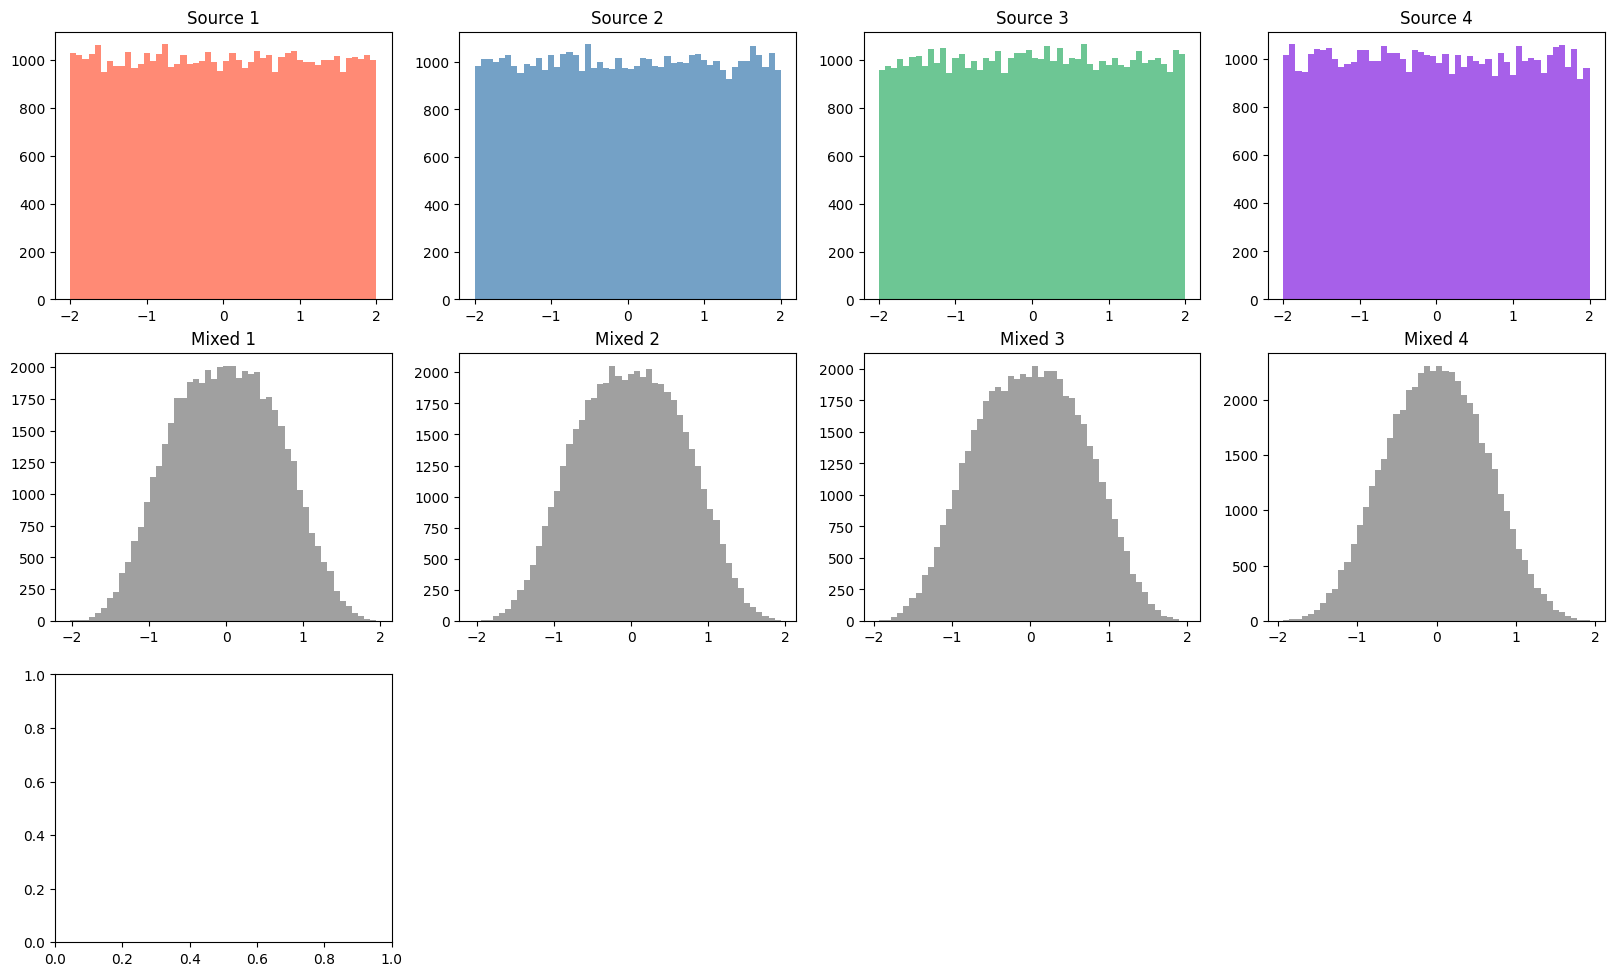

interactive(children=(Dropdown(description='Source 1', index=1, options=('gaussian', 'uniform', 'laplace', 'tr…

<function __main__.<lambda>(source1, source2, source3, source4, n_samples, noise_amp)>

In [6]:
# Example of a user-defined ICA function (placeholder)
def run_ica_example(X):
    n_components = 4
    ica = NaturalGradientICA(n_components=4, whiten=False, max_iter=5000, mu=.1, mu_gamma=.01)
    ica.fit(X)
    S_ = ica.transform(X)
    A_ = ica.weights  # Get estimated mixing matrix

    return S_, A_

distribution_choices = ['gaussian', 'uniform', 'laplace', 'triangular', 'exponential']
interact(lambda source1, source2, source3, source4, n_samples, noise_amp: interactive_ica(source1, source2, source3, source4, n_samples, noise_amp, run_ica_example),
         source1=Dropdown(options=distribution_choices, value='uniform', description='Source 1'),
         source2=Dropdown(options=distribution_choices, value='uniform', description='Source 2'),
         source3=Dropdown(options=distribution_choices, value='uniform', description='Source 3'),
         source4=Dropdown(options=distribution_choices, value='uniform', description='Source 4'),
         n_samples=IntSlider(min=1000, max=100000, step=10000, value=50000, description='Samples'),
         noise_amp=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Noise Amplitude'))